# Adult income

This notebook focuses on modeling using sklearn.

## 1. Data preparation

Algorithms for training need that the whole data is numeric, for that reason both categorical and target variables are going to be transformed into numeric values. With respect to numeric features, these must be in the same scale in order to improve training performance.

Finally, it is important to determine if all features are useful for training or some of them are only noise.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("ggplot")

In [3]:
PATH_DATA = os.path.join(os.getenv("PATH_DATA_PROJECTS"), "Tabular", "adult_income")

In [4]:
df_train = pd.read_csv(os.path.join(PATH_DATA, "adult_train_cleaned.csv"))
print("Shape:", df_train.shape)
df_train.head()

Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### 1.1. Categorical

In [6]:
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

#### 1.1.1. Hypothesis testing to identify which features are significant.

In [7]:
from scipy.stats import chi2_contingency

In [8]:
for c in categorical_features:
    contingency_table = pd.crosstab(df_train[c], df_train["income"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f"Reject the null hypothesis: There is a significant association between {c} and income.")
    else:
        print(f"Fail to reject the null hypothesis: No significant association between {c} and income.")

Reject the null hypothesis: There is a significant association between workclass and income.
Reject the null hypothesis: There is a significant association between education and income.
Reject the null hypothesis: There is a significant association between marital-status and income.
Reject the null hypothesis: There is a significant association between occupation and income.
Reject the null hypothesis: There is a significant association between relationship and income.
Reject the null hypothesis: There is a significant association between race and income.
Reject the null hypothesis: There is a significant association between sex and income.
Reject the null hypothesis: There is a significant association between native-country and income.


All categorical features have a significant relation with the target variable, so none of them can be removed.

#### 1.1.2. Data transformation

The transformer selected is OneHotEncoder, because none of the variables had ordinal values. So, all classes have the same meaning with respect to weight or position.

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
# Get transformer instance 
# sparse_output = False to return the values as vectors
# drop = first to remove first class, because the rest of classes are enough explanatory and reduce training time 
onehot_encoder = OneHotEncoder(sparse_output = False, drop = "first")

# Training
encoded_features = onehot_encoder.fit_transform(df_train[categorical_features])

# Turn result into a dataframe
df_one_hot_encoder = pd.DataFrame(encoded_features, columns = onehot_encoder.get_feature_names_out())

### 1.2. Numeric

Apply scaling transformation.

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
numeric_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

In [13]:
scaler = MinMaxScaler()
ar = scaler.fit_transform(df_train[numeric_features])
df_numeric = pd.DataFrame(ar, columns = numeric_features)

for c in numeric_features:
    df_train[c] = df_numeric[c]
    
print("Shape:", df_train.shape)
df_train.head()

Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,State-gov,0.044302,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.048238,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,0.138113,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States,<=50K
3,0.493151,Private,0.151068,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States,<=50K
4,0.150685,Private,0.221488,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba,<=50K


<Axes: title={'center': 'Numeric features distribution'}, ylabel='Density'>

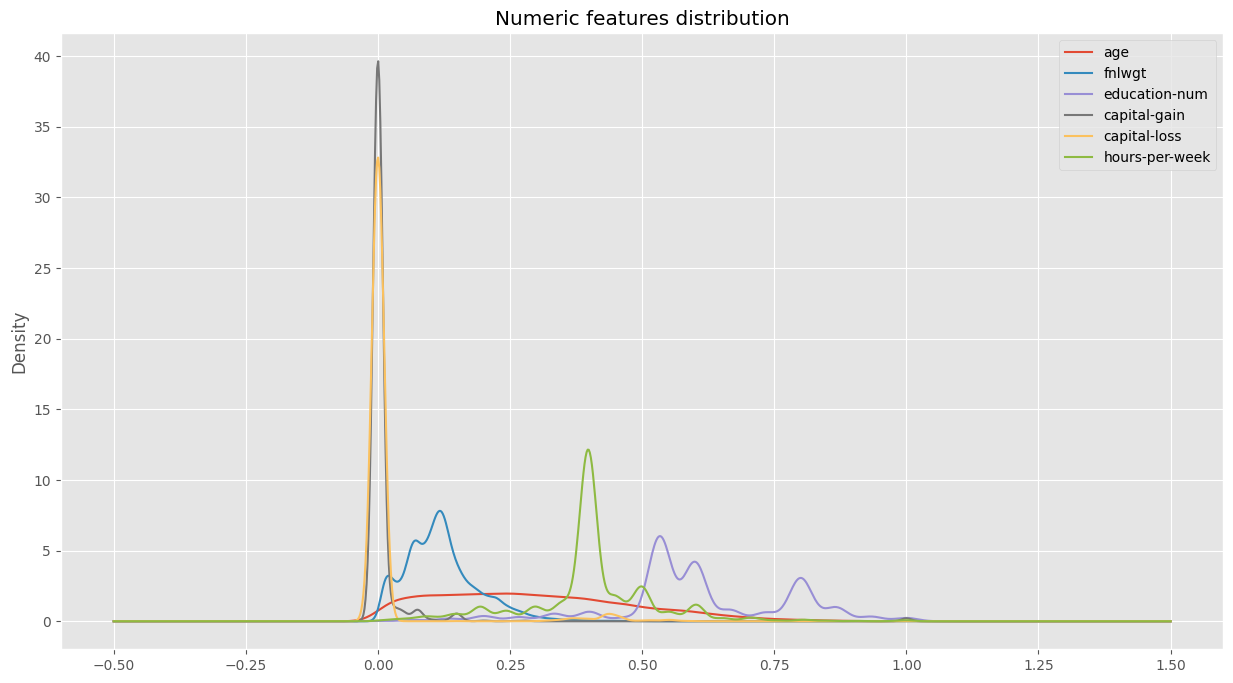

In [14]:
df_train[numeric_features].plot(kind = "kde", figsize = (15, 8), title = "Numeric features distribution")

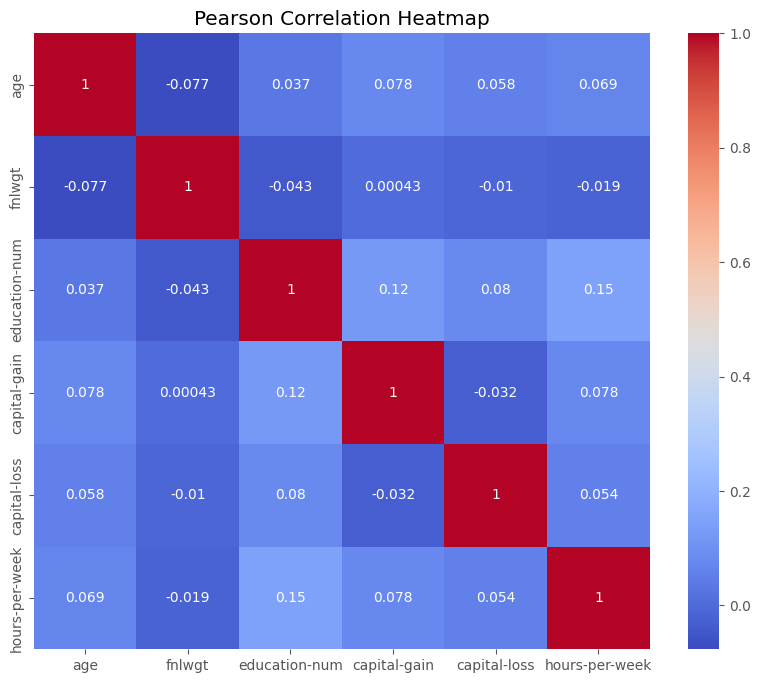

In [15]:
correlation_matrix = df_train[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Pearson Correlation Heatmap')
plt.show()

There is no a strong correlation among numeric variable, so none of them can be removed.

### 1.3. Target variable

Turn text into a number with the values: 0 = <=50K and 1 = >50K.

In [16]:
target_variable = "income"
df_train[target_variable] = df_train[target_variable].map(lambda x: 0 if x == "<=50K" else 1)
df_train[target_variable].unique()

array([0, 1])

### 1.4. Get transformed dataset

In [17]:
df_train_encoded = pd.concat([df_train[numeric_features], df_one_hot_encoder, df_train[target_variable]], axis = 1)
print("Shape:", df_train_encoded.shape)
df_train_encoded.head()

Shape: (32561, 98)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.452055,0.048238,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.287671,0.138113,0.533333,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0.493151,0.151068,0.400000,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.150685,0.221488,0.800000,0.00000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## 2. Modeling

### 2.1. Split data into training and validation

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x = df_train_encoded.drop(target_variable, axis = 1).values
y = df_train_encoded[target_variable].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (26048, 97)
x_val shape: (6513, 97)
y_train shape: (26048,)
y_val shape: (6513,)


### 2.2. Training

For training models there are three main points:

* Test different machine learning algorithms for binary classification problem.
* Apply hyperparameter tuning using random search technique.
* Some hyperparameters like class_weight = balanced are set beforehand, because of class imbalance problem.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV

#### Logistic regression

In [21]:
lg = LogisticRegression(class_weight = "balanced", penalty = "l2")

param_grid = {
    # Regularization strength, smaller values specify stronger regularization
    "C": [0.01, 0.1, 1, 10, 100],

    # Optimizer algorithm
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

clf = RandomizedSearchCV(lg, param_grid, random_state = 0, cv = 3, verbose = 2, n_jobs = -1)
random_search_lg = clf.fit(x_train, y_train)

print("\nBest hyperparameters:", random_search_lg.best_params_)
print("\nBest score: ", random_search_lg.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters: {'solver': 'liblinear', 'C': 100}

Best score:  0.809505624971364


#### Random forest

In [22]:
rfc = RandomForestClassifier()

param_grid = {
    # Number of trees to increase model complexity
    "n_estimators": [100, 200, 500],

    # Maximum depth of each tree
    "max_depth": [None, 10, 20, 30, 40, 50],

    # Minimum number of samples required to split an internal node, small number can lead to overfitting
    "min_samples_split": [2, 5, 10],

    # Minimum number of samples required to be at a leaf node, small number can lead to overfitting
    "min_samples_leaf": [1, 2, 4],

    # Number of features to consider when looking for the best split, small number reduce variance
    #"max_features": ["auto", "sqrt", "log2"],

    # Add weights inversely proportional to each class based on its frequency
    "class_weight": ["balanced", "balanced_subsample"]
}

clf = RandomizedSearchCV(rfc, param_grid, random_state = 0, cv = 3, verbose = 2, n_jobs = -1)
random_search_rfc = clf.fit(x_train, y_train)

print("\nBest hyperparameters:", random_search_rfc.best_params_)
print("\nBest score: ", random_search_rfc.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'class_weight': 'balanced'}

Best score:  0.854883446714978


#### Neural Networks

In [23]:
mlpc = MLPClassifier(max_iter = 500)

param_grid = {
    # Number of neurons in each hidden layer, more layers, more complex model
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50), (100, 100)],

    # Activation function for the hidden layers
    "activation": ["identity", "logistic", "tanh", "relu"],

    # Optimizer algorithm
    "solver": ["lbfgs", "sgd", "adam"],

    # L2 penalty strength
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],

    # How learning rate changes
    "learning_rate": ["constant", "invscaling", "adaptive"],

    # Initial learning rate used
    "learning_rate_init": [0.001, 0.01, 0.1],

    # Maximum number of iterations
    #"max_iter": [200, 300, 500]
}

clf = RandomizedSearchCV(mlpc, param_grid, random_state = 0, cv = 3, verbose = 2, n_jobs = -1)
random_search_mlpc = clf.fit(x_train, y_train)

print("Best hyperparameters:", random_search_mlpc.best_params_)
print("Best score: ", random_search_mlpc.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'solver': 'sgd', 'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'logistic'}
Best score:  0.8510443376215058


### 2.3. Evaluation

This is a classification problem, so the following metrics are necessary:

* **Accuracy**: proportion of correctly predicted to the total of all instances.
* **Precision**: proportion of correctly predicted positive to the total of all predicted positive. When False Positive cost is high.
* **Recall**: proportion of correctly predicted positive to the total of all positive. When False Negative cost is high.
* **F1 score**: mean of precision and recall.
* **ROC curve**: True positive rate (TPR) vs False positive rate (FPR) plot. Close to TPR is good, because measures how good a model is for prediction.
* **AUC score**: Area under the ROC curve. Result equal to 1 is perfect model. 
* **Confusion matrix**: table which shows True Positives, True Negatives, False Positives and False Negatives.
* **Classification report**: summary of the most common metrics.

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score

#### Logistic regression

In [25]:
# Prediction
y_pred = random_search_lg.predict(x_val)

# Probabilities for ROC AUC
y_prob = random_search_lg.predict_proba(x_val)[:, 1]

# Accuracy
print("\nAccuracy:", accuracy_score(y_val, y_pred))

# Precision
print("\nPrecision:", precision_score(y_val, y_pred))

# Recall
print("\nRecall:", recall_score(y_val, y_pred))

# F1
print("\nF1:", f1_score(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.8071549209273761

Precision: 0.5673364685763147

Recall: 0.8446849140674729

F1: 0.6787723785166241

Confusion Matrix:
[[3930 1012]
 [ 244 1327]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      4942
           1       0.57      0.84      0.68      1571

    accuracy                           0.81      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513




ROC AUC Score: 0.9069545364033096


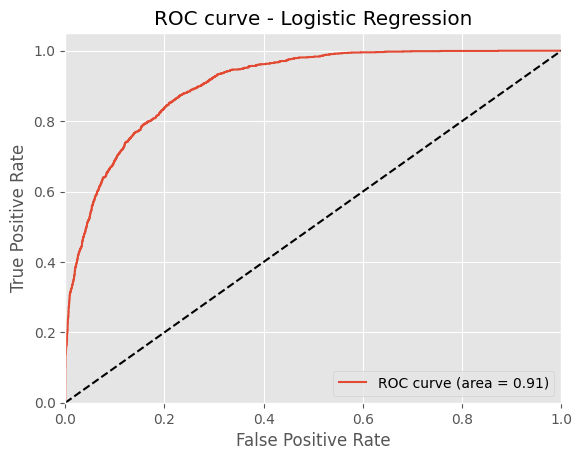

In [26]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Logistic Regression")
plt.legend(loc = "lower right")
plt.show()

#### Random forest

In [27]:
# Prediction
y_pred = random_search_rfc.predict(x_val)

# Probabilities for ROC AUC
y_prob = random_search_rfc.predict_proba(x_val)[:, 1]

# Accuracy
print("\nAccuracy:", accuracy_score(y_val, y_pred))

# Precision
print("\nPrecision:", precision_score(y_val, y_pred))

# Recall
print("\nRecall:", recall_score(y_val, y_pred))

# F1
print("\nF1:", f1_score(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.8616612927990174

Precision: 0.710691823899371

Recall: 0.7192870782940802

F1: 0.7149636191078772

Confusion Matrix:
[[4482  460]
 [ 441 1130]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4942
           1       0.71      0.72      0.71      1571

    accuracy                           0.86      6513
   macro avg       0.81      0.81      0.81      6513
weighted avg       0.86      0.86      0.86      6513




ROC AUC Score: 0.9121102046630797


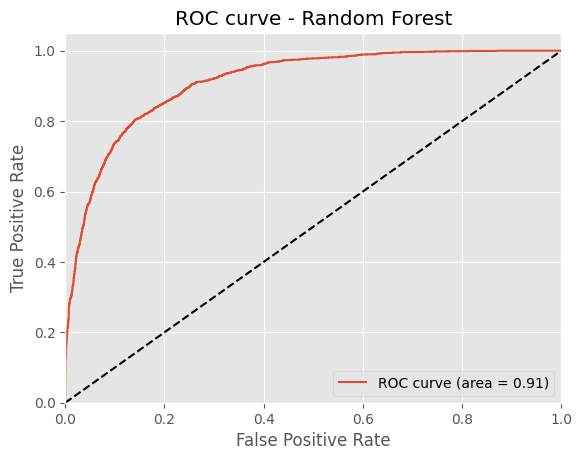

In [28]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Random Forest")
plt.legend(loc = "lower right")
plt.show()

#### Neural Networks

In [29]:
# Prediction
y_pred = random_search_mlpc.predict(x_val)

# Probabilities for ROC AUC
y_prob = random_search_mlpc.predict_proba(x_val)[:, 1]

# Accuracy
print("\nAccuracy:", accuracy_score(y_val, y_pred))

# Precision
print("\nPrecision:", precision_score(y_val, y_pred))

# Recall
print("\nRecall:", recall_score(y_val, y_pred))

# F1
print("\nF1:", f1_score(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.8578228159066482

Precision: 0.7373068432671082

Recall: 0.6378103119032463

F1: 0.6839590443686007

Confusion Matrix:
[[4585  357]
 [ 569 1002]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4942
           1       0.74      0.64      0.68      1571

    accuracy                           0.86      6513
   macro avg       0.81      0.78      0.80      6513
weighted avg       0.85      0.86      0.85      6513




ROC AUC Score: 0.9115683365615294


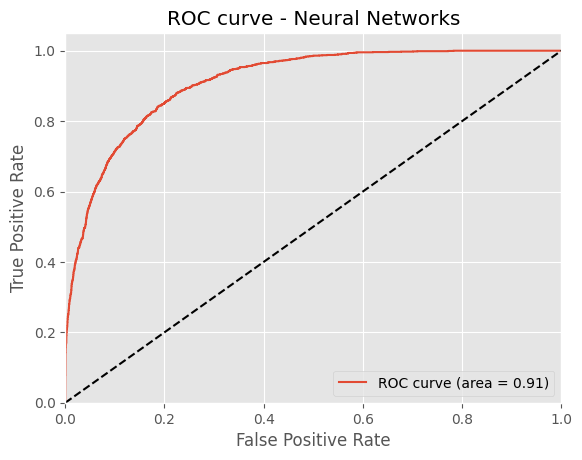

In [30]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.figure()
plt.plot(fpr, tpr, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Neural Networks")
plt.legend(loc = "lower right")
plt.show()

### 2.4. Pipeline script

In [31]:
%%writefile src/adult_income_sklearn_script.py
import argparse
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type = str, help = "Data location")
args = parser.parse_args()
# Read data
print("\nReading data")
df_train = pd.read_csv(args.data_path)
print("\nData is done")

# Data for training and validation
print("\nStarting defining the data for training and validation")
target_variable = "income"
df_train = pd.read_csv(args.data_path)
x = df_train.drop(target_variable, axis = 1)
y = df_train[target_variable]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("\nData for training and testing are done")

# Data transformation
print("\nStarting applying target variable transformation")
y_train = y_train.map(lambda x: 0 if x == "<=50K" else 1)
y_val = y_val.map(lambda x: 0 if x == "<=50K" else 1)
print("\nTarget variable transformation is done")

print("\nStarting defining data transformation steps for categorical features")
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OneHotEncoder(sparse_output = False, drop = "first"), categorical_features)
    ])
print("\nData transformation for categorical features is done")

# Classifiers
print("\nStarting defining the classifiers")
logistic = LogisticRegression(class_weight = "balanced")
random_forest = RandomForestClassifier()
mlp = MLPClassifier()
print("\nClassifiers are done")

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", logistic)
])

# Hyperparameters per classifier
print("\nStarting defining the hyperparameters")
param_grid = [
    {
        "classifier": [logistic],

        # Regularization strength, smaller values specify stronger regularization
        "classifier__C": [0.01, 0.1, 1, 10, 100],

        # Optimizer algorithm
        "classifier__solver": ["liblinear", "sag", "saga"],

        "classifier__penalty": ["l2"]
    }
]
print("\nHyperparameters are done")

# Training
print("\nStarting training")
random_search = RandomizedSearchCV(pipeline, param_grid, n_iter = 100, cv=3, verbose = 2, random_state = 42, n_jobs = -1)
random_search.fit(x_train, y_train)

print("Best hyperparameters:", random_search.best_params_)
print("Best score: ", random_search.best_score_)

print("\nTraining is done")

# Prediction
print("\nStarting evaluation")
y_pred = random_search.predict(x_val)

# Probabilities for ROC AUC
y_prob = random_search.predict_proba(x_val)[:, 1]

# Classification Report
print("\nClassification Report:", classification_report(y_val, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:", confusion_matrix(y_val, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_prob)
print("\nROC AUC Score:", roc_auc)

# Precision-Recall AUC Score
average_precision = average_precision_score(y_val, y_prob)
print("\nPrecision-Recall AUC Score:", average_precision)

print("\Evaluation is done")

Overwriting src/adult_income_sklearn_script.py
